In [1]:
import os
import json
import copy
import warnings
import folium # version 0.5.0
import pandas as pd # version 0.20.3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # version 0.8
from IPython.display import Image
%matplotlib inline

warnings.filterwarnings('ignore')
folium.TopoJson;

sns.set(style="whitegrid")
sns.set(font_scale=1.2)

MIDDLE_EU = [53.5775, 23.106111]
MIDDLE_CH = [46.801111, 8.226667]

WORKING_DIR = os.getcwd()
FILE_UNEMPLOYMENT_CH = '3_1Moyennedeschômeursettauxdechômageparan.csv'
FILE_JOB_SEEKERS = '1_1Chômeursetdemandeursd_emploiselondiverscritères_total.csv'
FILE_JOB_SEEKERS_EMPLOYED = '1_1Chômeursetdemandeursd_emploiselondiverscritères_nonchomeurs.csv'
FILE_RATES_FOREIGNERS = '3_1Moyennedeschômeursettauxdechômageparan_nat.xlsx'
FILE_RATES_AGE = '3_1Moyennedeschômeursettauxdechômageparan_age.xlsx'
TOPOJSON_EU_PATH = os.path.join(WORKING_DIR, 'topojson', 'europe.topojson.json')
TOPOJSON_CH_PATH = os.path.join(WORKING_DIR, 'topojson', 'ch-cantons.topojson.json')
TABLES_FOLDER = os.path.join(WORKING_DIR, 'tables')
COUNTRIES_PATH = os.path.join(TABLES_FOLDER, 'countries.csv')
UNEMPLOYMENT_EU_PATH = os.path.join(TABLES_FOLDER, 'une_rt_a.tsv') 
UNEMPLOYMENT_CH_PATH = os.path.join(TABLES_FOLDER, FILE_UNEMPLOYMENT_CH)
JOB_SEEKERS_PATH = os.path.join(TABLES_FOLDER, FILE_JOB_SEEKERS)
JOB_SEEKERS_EMPLOYED_PATH = os.path.join(TABLES_FOLDER, FILE_JOB_SEEKERS_EMPLOYED)
UNEMPLOYMENT_CH_FOREIGNERS = os.path.join(TABLES_FOLDER, FILE_RATES_FOREIGNERS)
UNEMPLOYMENT_CH_AGE = os.path.join(TABLES_FOLDER, FILE_RATES_AGE)
FIGURES_FOLDER = os.path.join(WORKING_DIR, 'figures')


VALID_EU = {'Belgium': 'BE', 'Greece': 'EL', 'Lithuania': 'LT', 
            'Portugal': 'PT', 'Bulgaria': 'BG', 'Spain': 'ES', 
            'Luxembourg': 'LU','Romania': 'RO', 'Czech Republic': 'CZ',
            'France': 'FR', 'Hungary': 'HU', 'Slovenia': 'SI',
            'Denmark': 'DK', 'Croatia': 'HR', 'Malta': 'MT', 
            'Slovakia':'SK', 'Germany': 'DE', 'Italy': 'IT', 
            'Netherlands': 'NL', 'Finland': 'FI', 'Estonia': 'EE', 
            'Cyprus': 'CY', 'Austria': 'AT', 'Sweden': 'SE',
            'Ireland': 'IE', 'Latvia': 'LV', 'Poland': 'PL', 
            'United Kingdom': 'UK'}

LOOKUP_CANTONS = {'Zurich': 'Zürich', 'Berne': 'Bern/Berne', 'Lucerne': 
                  'Luzern', 'Uri': 'Uri', 'Schwyz': 'Schwyz', 
                  'Obwald': 'Obwalden', 'Nidwald': 'Nidwalden', 'Glaris': 'Glarus',
                  'Zoug': 'Zug', 'Fribourg': 'Fribourg', 'Soleure': 'Solothurn',
                  'Bâle-Ville': 'Basel-Stadt', 'Bâle-Campagne': 'Basel-Landschaft', 
                  'Schaffhouse': 'Schaffhausen', 
                  'Appenzell Rhodes-Extérieures': 'Appenzell Ausserrhoden',
                  'Appenzell Rhodes-Intérieures': 'Appenzell Innerrhoden', 
                  'St-Gall': 'St. Gallen', 'Grisons': 'Graubünden/Grigioni', 
                  'Argovie': 'Aargau', 'Thurgovie': 'Thurgau', 
                  'Tessin': 'Ticino', 'Vaud': 'Vaud', 'Valais': 
                  'Valais/Wallis', 'Neuchâtel': 'Neuchâtel',
                  'Genève': 'Genève', 'Jura': 'Jura'}

# 1

[Eurostat](http://ec.europa.eu/eurostat/data/database) has a lot of different files with information about unemployment. Some of them just contains information about Europe Union as [here](http://ec.europa.eu/eurostat/web/products-datasets/-/tsdec450) and others have a lot of missing values. We opted to choose the metrics that followed the **European Union labour force survey** as its definition can be found [here](http://ec.europa.eu/eurostat/statistics-explained/index.php/EU_labour_force_survey_-_methodology) and the tables split by sex and gender can be dowloaded [here](http://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/une_rt_a.tsv.gz) and the image below shows how to download it too.


<img src="figures/unemployment_eu_page.png" style="width: 700px;"/>


The information of country name and abbreviation can be found [here](https://datahub.io/core/country-list#resource-country-list_zip)


In [2]:
raw_unemployment_eu = pd.read_csv(UNEMPLOYMENT_EU_PATH, sep='\t')
raw_unemployment_ch = pd.read_csv(UNEMPLOYMENT_CH_PATH, encoding='utf-16-le')
raw_job_seekers_ch = pd.read_csv(JOB_SEEKERS_PATH, encoding='utf-16-le')
raw_job_seekers_employed_ch = pd.read_csv(JOB_SEEKERS_EMPLOYED_PATH, encoding='utf-16-le')
raw_unemployment_ch_nat = pd.read_excel(UNEMPLOYMENT_CH_FOREIGNERS, skiprows = 2)
raw_unemployment_ch_nat = raw_unemployment_ch_nat[['Canton', 'Nationalité', 'Taux de chômage (1 cav)']]
raw_unemployment_ch_age = pd.read_excel(UNEMPLOYMENT_CH_AGE, skiprows = 2)
raw_unemployment_ch_age = raw_unemployment_ch_age[['Canton', 'Classes d\'âge par étapes de 5 ans', 'Taux de chômage (1 cav)']]
raw_unemployment_ch_age.rename(columns = {'Classes d\'âge par étapes de 5 ans' : 'Age Group',
                                          'Taux de chômage (1 cav)' : 'Unemployment Rate'}, inplace = True)
countries = pd.read_csv(COUNTRIES_PATH).rename(columns={'Code': 'geotime'})
topojson_eu = json.load(open(TOPOJSON_EU_PATH))
topojson_ch = json.load(open(TOPOJSON_CH_PATH))

In [3]:
def treat_raw_unemployment(df):
    '''Filter valid years, filter valid countries, 
       replace missing by nans, split columns, filter unit.
       Besides that, it will merge with the list of countries names''' 
    new_cols = map(lambda x: x.replace(' ', '').replace('\\', '') , list(df.columns))
    df.columns = new_cols
    VALID_COLS = ['age,unit,sex,geotime', '2016', '2015', '2014', '2013', '2012']
    df = df[VALID_COLS]
    df = df.replace(': ', np.nan)
    str_to_cols = pd.DataFrame(df['age,unit,sex,geotime']
                               .str.split(',').tolist(), 
                               columns='age,unit,sex,geotime'.split(','))
    
    df = pd.concat([df, str_to_cols], axis=1)
    df['is_union'] = df['geotime'].apply(lambda x: x in VALID_EU.values())
    df = df[df['unit']=='PC_ACT']
    df = df[df['age']=='TOTAL']
    df = df[df['geotime']!='JP'] # couldnt find which country is it
    
    df = df.merge(countries, on='geotime', how='left')
    df['Name'] = df.apply(lambda x: x['Name'] if pd.notnull(x['Name']) else x['geotime'], axis=1)
    
    return df
        
unemployment_eu = treat_raw_unemployment(raw_unemployment_eu)

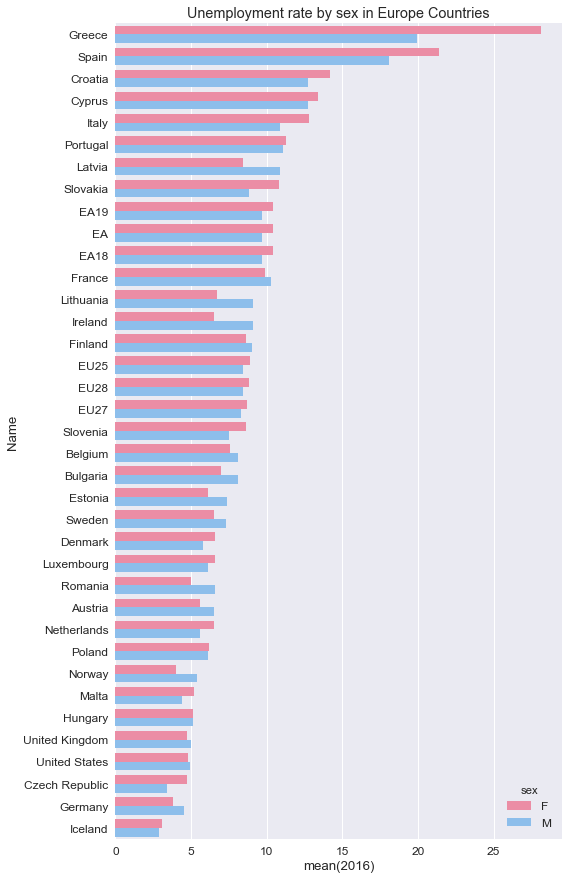

In [4]:
woman = unemployment_eu[unemployment_eu.sex == 'F']
man = unemployment_eu[unemployment_eu.sex == 'M']
woman_man = pd.concat([woman, man], axis=0).sort_values('2016', ascending=False)
f, ax = plt.subplots(figsize=(8, 15))
ax = sns.barplot(y='Name', x='2016', hue='sex', data=woman_man, saturation=0.8, palette=['#F7819F', '#81BEF7']);
ax.set_title('Unemployment rate by sex in Europe Countries')
ax;

Countries with high unemployment rates, woman group has a higher rate compared with man's group. For countries with low unemployment rates, the rates between tow groups are about the same and sometimes woman's group is better than man's

In [5]:
def treat_and_filter_eu(topojson):
    '''filter countries that exists in unemployment file from Eurostat'''
    new_topojson = copy.deepcopy(topojson)
    eu_countries = VALID_EU.values()
    geometries =  new_topojson['objects']['europe']['geometries']
    
    for g in geometries:
        if g['id']=='GB':
            g['id'] = 'UK'
        if g['id']=='GR':
            g['id'] = 'EL'
            
    filtered_eu = list(filter(lambda x: x['id'] in set(unemployment_eu.geotime), geometries))
    new_topojson['objects']['europe']['geometries'] = filtered_eu
    return new_topojson
                      
filtered_topojson_eu = treat_and_filter_eu(topojson_eu)

In [6]:
map_eu = folium.Map(location=MIDDLE_EU, tiles='Mapbox Bright', zoom_start=4)
total_unemployment_eu = unemployment_eu[unemployment_eu.sex=='T']

map_eu.choropleth(geo_data=filtered_topojson_eu, data=total_unemployment_eu, 
                  columns=['geotime', '2016'],
                  key_on='feature.id',
                  topojson='objects.europe',
                  fill_color='YlOrRd', 
                  fill_opacity=0.7, 
                  line_opacity=0.8,
                  legend_name='Unemployment 2016 EU',)
map_eu.save(os.path.join(FIGURES_FOLDER, 'unemployment_eu.html'))


> ## [EU unemployment Map](https://cdn.rawgit.com/liabifano/CS-401/8c76fc5b/homework_3/figures/unemployment_eu.html)

As expected Greece has the highest unemployment rate which is consistency with the news from the last year.
Italy and Spain also have high rates and are having problems since crisis euro to revert this scenario.

### EU Unemployment compared with Switzerland 
The information regarding Switzerland unemployment is in the section `3.1 Moyenne des chomeurs et taux de chomage par an` inside the `details` section and then select the year of 2016. The unemployment is split by canton, so the weighted average based on the number of people will be taken to calculate the entire rate of the country, which is the quantity of job seekers.
However the number of active people is not in the dataset, just the number of unemployed, so it will have to be calculated.


$$
active\_population = \frac{number\_unemployed}{unemployment\_rate}
$$

In [7]:
def treat_raw_unemployment_ch(df):
    df = df[['Canton', 'durchschnittliche Anzahl Arbeitslose', 'Taux de chômage (1 cav)']]
    df = df.rename(columns={'Taux de chômage (1 cav)': 'rate_unemployement', 
                            'durchschnittliche Anzahl Arbeitslose': 'avg_unemployed'})
    df['avg_unemployed'] = pd.to_numeric(df['avg_unemployed'].str.replace("\'", ''))
    df['active_population'] = df['avg_unemployed'] / (df['rate_unemployement']/100)
    
    return df

In [8]:
unemployment_ch = treat_raw_unemployment_ch(raw_unemployment_ch)
print('Number of active population: {n}'.format(n=round(unemployment_ch['active_population'].sum(), 0)))

Number of active population: 4487551.0


In [9]:
agg_unemployment_ch = np.average(unemployment_ch['rate_unemployement'], weights=unemployment_ch['active_population'])
print('Aggregated unemployment in Switzerland: {r}'.format(r=round(agg_unemployment_ch, 3)))

Aggregated unemployment in Switzerland: 3.327


The rate of unemployment is consistency with the report [here](https://tradingeconomics.com/switzerland/unemployment-rate/forecast)

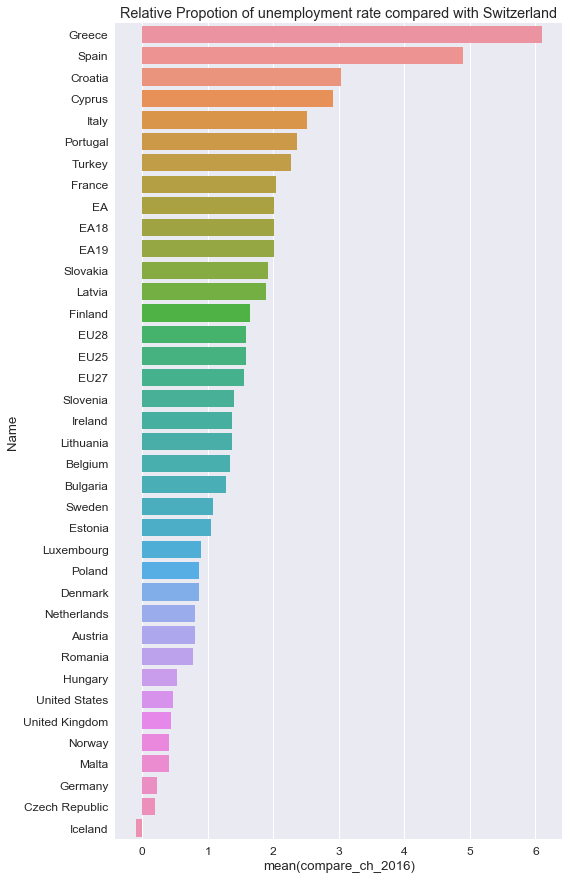

In [10]:
total_unemployment_eu['compare_ch_2016'] = (total_unemployment_eu['2016'] - agg_unemployment_ch) / agg_unemployment_ch
f, ax = plt.subplots(figsize=(8, 15))
ax = sns.barplot(y='Name', x='compare_ch_2016', data=total_unemployment_eu.sort_values('compare_ch_2016', ascending=False), saturation=0.8);
ax.set_title('Relative Propotion of unemployment rate compared with Switzerland')
ax;

The only country with rate better than Switzerland is Iceland. As we can see from the map, the average rate of Switzerland if about half of the Europen Union.

In [11]:
map_eu = folium.Map(location=MIDDLE_EU, tiles='Mapbox Bright', zoom_start=4)

map_eu.choropleth(geo_data=filtered_topojson_eu, data=total_unemployment_eu, 
                  columns=['geotime', 'compare_ch_2016'],
                  key_on='feature.id',
                  topojson='objects.europe',
                  fill_color='YlOrRd', 
                  fill_opacity=0.7, 
                  line_opacity=0.8,
                  legend_name='Unemployment 2016 EU relative with Switzerland',)
map_eu.save(os.path.join(FIGURES_FOLDER, 'unemployment_eu_compare_switzerland.html'))

> ## [EU Unemployment compared with Switzerland Map](https://cdn.rawgit.com/liabifano/CS-401/8c76fc5b/homework_3/figures/unemployment_eu_compare_switzerland.html)

## 2

Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

 Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

   The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

   Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.



The information regarding Switzerland unemployment is in the section `3.1 Moyenne des chomeurs et taux de chomage par an` inside the `details` section and then select the year of 2016.

In [12]:
def treat_topojson_ch(topojson):
    new_topojson = copy.deepcopy(topojson)
    geometries = new_topojson['objects']['cantons']['geometries']
    inv_lookup = {v: k for k, v in LOOKUP_CANTONS.items()}
    
    for g in geometries:
        g['properties']['name'] = inv_lookup.get(g['properties']['name'])
        
    new_topojson['objects']['cantons']['geometries'] = geometries
        
    return new_topojson

In [13]:
treated_topojson_ch = treat_topojson_ch(topojson_ch)
id_canton = dict(list(map(lambda x: (x['properties']['name'], x['id']), treated_topojson_ch['objects']['cantons']['geometries'])))
unemployment_ch['id'] = unemployment_ch['Canton'].apply(lambda x: id_canton.get(x))
unemployment_ch.loc[0, 'id'] = 'ZH'
unemployment_ch.loc[17, 'id'] = 'GR'
unemployment_ch.loc[23, 'id'] = 'NE'
unemployment_ch.loc[24, 'id'] = 'GE'

In [14]:
map_ch = folium.Map(location=MIDDLE_CH, tiles='Mapbox Bright', zoom_start=8)

map_ch.choropleth(geo_data=treated_topojson_ch, data=unemployment_ch, 
                  columns=['id', 'rate_unemployement'],
                  key_on='feature.id',
                  topojson='objects.cantons',
                  fill_color='YlOrRd', 
                  fill_opacity=0.7, 
                  line_opacity=0.8,
                  legend_name='Unemployment 2016 in Switzerland')
map_ch.save(os.path.join(FIGURES_FOLDER, 'unemployment_switzerland_by_canton.html'))

> ## [Unemployment by Canton Map](https://cdn.rawgit.com/liabifano/CS-401/8c76fc5b/homework_3/figures/unemployment_switzerland_by_canton.html)

Cantons close to germany tend to have a lower unemployment rate than the rest of the Cantons (French and Italian spearker). This trend was also mentioned in the news as we can check in the [lenews](http://lenews.ch/2015/02/12/swiss-unemployment-linked-to-language-and-passport/) newspapers. The table below shows the number worst cantons:

In [15]:
unemployment_ch.sort_values('rate_unemployement', ascending=False)[['Canton', 'rate_unemployement']].head()

,Canton,rate_unemployement
23,Neuchâtel,5.8
24,Genève,5.5
21,Vaud,4.7
25,Jura,4.6
11,Bâle-Ville,3.9


The rate of unemployment seems to be uncorrelated with the number of active people by Canton. The definition of active people is defined in section 1.

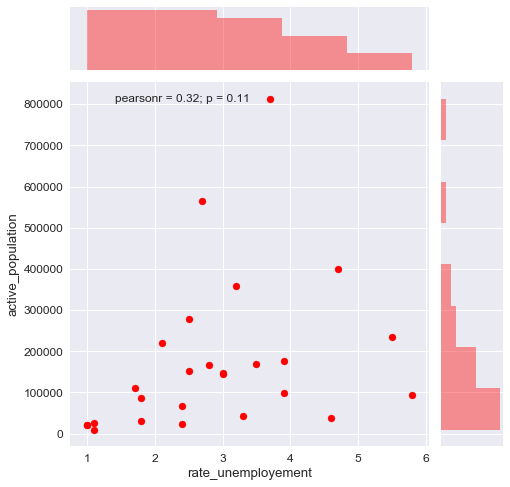

In [16]:
sns.jointplot('rate_unemployement', 'active_population', data=unemployment_ch, kind='scatter', color="r", size=7)

To find tables with the information about people that is looking for a job that don't have a employment or have a employment, navegate in the website [amstat](https://www.amstat.ch/v2/index.jsp) and then:

`Détails` > `2 Chomerus et demandeurs d'emploi` > `1.1 Chomerues et demandeurs d'emploi selon divers criteres`. 

After these steps you have to select the information that you want to, the image below shows how the information were selected. The red arrow indicates how to select the total number of job seekers and the arrow purple indicates the total of job seekers that have alreay a job.


<img src="figures/unemployments_ch_page.png" style="width: 700px;"/>

Finally, you have to manually select all the months for the analysis and you arrive in a table as below:

<img src="figures/database_page_ch.png" style="width: 700px;"/>

As the information is by month, we will take the average in order to analyse each canton.

In [17]:
def treat_job_seekers(df):
    '''filter relevent columns because chomeurs inscrits is not a valid one,
       convert columns to numneric, rename columns, 
       calculate annual average'''
    df = df[df['NOGA 08 à 2 chiffres'] == 'Total']
    valid_columns = list(filter(lambda x: x.split('.')[-1] == '1', list(df.columns)))
    df = df[['Canton'] + valid_columns]
    renamed_columns = list(map(lambda x: x.split('.')[0], valid_columns))
    df = df.rename(columns=dict(list(zip(valid_columns, renamed_columns))))
    
    for c in renamed_columns:
        df[c] = pd.to_numeric(df[c].str.replace("\'", ''))
    df['annual_mean'] = np.mean(df[renamed_columns], axis=1)
    
    return df
    
job_seekers_ch = treat_job_seekers(raw_job_seekers_ch)
job_seekers_employed_ch = treat_job_seekers(raw_job_seekers_employed_ch)

merged_job_seekers = (job_seekers_ch
                      .rename(columns={'annual_mean': 'annual_mean_total'})
                      .merge(job_seekers_employed_ch
                             .rename(columns={'annual_mean': 'annual_mean_employed'}),
                             on='Canton', how='inner')
                      [['Canton', 'annual_mean_employed', 'annual_mean_total']])
merged_job_seekers['prop_seekers_employed'] = merged_job_seekers['annual_mean_employed'] / merged_job_seekers['annual_mean_total']
merged_job_seekers = merged_job_seekers.merge(unemployment_ch, on='Canton', how='inner')

In [18]:
merged_job_seekers = (merged_job_seekers[['id', 'Canton', 'active_population', 'rate_unemployement', 'prop_seekers_employed']]
                      .sort_values('prop_seekers_employed', ascending=False))

In [19]:
map_ch_seekers = folium.Map(location=MIDDLE_CH, tiles='Mapbox Bright', zoom_start=8)

map_ch_seekers.choropleth(geo_data=treated_topojson_ch, data=merged_job_seekers, 
                  columns=['id', 'prop_seekers_employed'],
                  key_on='feature.id',
                  topojson='objects.cantons',
                  fill_color='YlOrRd', 
                  fill_opacity=0.7, 
                  line_opacity=0.8,
                  legend_name='Proportion of job seekers with jobs over the total of job seekers',)
map_ch_seekers.save(os.path.join(FIGURES_FOLDER, 'prop_job_seekers_with_job.html'))

> ## [Job Seekers by Canton Map](https://cdn.rawgit.com/liabifano/CS-401/33043f8f/homework_3/figures/prop_job_seekers_with_job.html)

From the map above, german spearks cantons have a higher proportion of employed job seekers than the other cantons. The table below show the correlation among `aticve population`, `rate_unemployment` and `prop_seekers_employed`.

In [20]:
merged_job_seekers.corr()

,active_population,rate_unemployement,prop_seekers_employed
active_population,1.000000,0.321182,-0.609565
rate_unemployement,0.321182,1.000000,-0.638362
prop_seekers_employed,-0.609565,-0.638362,1.000000


# 3
Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

   The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

   Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

   Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

To find tables with the information about unemployment of suisses and non-suisses, navegate in the website [amstat](https://www.amstat.ch/v2/index.jsp) and then:

`Détails` > `2 Chomerus et demandeurs d'emploi` > `3.1 Moyenne des chomeurs et taux de chomeurs par an`. 

After these steps you have to select the information that you want to, the image below shows how the information were selected.


<img src="figures/unemployments_foreigners_ch_page.png" style="width: 700px;"/>

In [21]:
raw_unemployment_ch_nat.head()

,Canton,Nationalité,Taux de chômage (1 cav)
0,Zurich,Etrangers,6.0
1,Zurich,Suisses,2.8
2,Berne,Etrangers,6.5
3,Berne,Suisses,2.0
4,Lucerne,Etrangers,4.7


In [22]:
#Rearranging the DatFrame

#Separating the data on Swiss Nationals
raw_unemployment_ch_nat_S = raw_unemployment_ch_nat[raw_unemployment_ch_nat['Nationalité'] == 'Suisses']
raw_unemployment_ch_nat_S.rename(columns = {'Taux de chômage (1 cav)' : 'Swiss Rate'}, inplace = True)
raw_unemployment_ch_nat_S.drop('Nationalité', axis = 1, inplace = True)

#Separating the data on Foreigners
raw_unemployment_ch_nat_F = raw_unemployment_ch_nat[raw_unemployment_ch_nat['Nationalité'] == 'Etrangers']
raw_unemployment_ch_nat_F.rename(columns = {'Taux de chômage (1 cav)' : 'Foreign Rate'}, inplace = True)
raw_unemployment_ch_nat_F.drop('Nationalité', axis = 1, inplace = True)

#Merging both to get two separate columns
unemployment_ch_nat = raw_unemployment_ch_nat_S.merge(raw_unemployment_ch_nat_F, left_on = 'Canton', right_on = 'Canton')

#Adding ID
unemployment_ch_nat['id'] = unemployment_ch_nat['Canton'].apply(lambda x: id_canton.get(x))
unemployment_ch_nat.loc[0, 'id'] = 'ZH'
unemployment_ch_nat.loc[17, 'id'] = 'GR'
unemployment_ch_nat.loc[23, 'id'] = 'NE'
unemployment_ch_nat.loc[24, 'id'] = 'GE'

unemployment_ch_nat.head()

,Canton,Swiss Rate,Foreign Rate,id
0,Zurich,2.8,6.0,ZH
1,Berne,2.0,6.5,BE
2,Lucerne,1.5,4.7,LU
3,Uri,0.6,4.2,UR
4,Schwyz,1.2,3.9,SZ


In [23]:
#Taking ratio of the rates to display comparison on map
unemployment_ch_nat['Ratio'] = unemployment_ch_nat['Foreign Rate'] / unemployment_ch_nat['Swiss Rate']

In [24]:
map_ch_nat = folium.Map(location=MIDDLE_CH, tiles='Mapbox Bright', zoom_start=8)

map_ch_nat.choropleth(geo_data=topojson_ch, data=unemployment_ch_nat, 
                  columns=['id', 'Ratio'],
                  key_on='feature.id',
                  topojson='objects.cantons',
                  fill_color='YlOrRd', 
                  fill_opacity=0.7, 
                  line_opacity=0.8,
                  legend_name='Unemployment Rate Ratio between Foreign and Swiss Citizens 2016')
map_ch_nat.save(os.path.join(FIGURES_FOLDER, 'unemployment_switzerland_by_canton_nat.html'))

> ## [Ratio of unemployment rate between Foreigners and Swiss Nationals by Canton Map](https://cdn.rawgit.com/liabifano/CS-401/33043f8f/homework_3/figures/unemployment_switzerland_by_canton_nat.html)

The highest disparity seems to be coming from Altdorf Canton.

In [25]:
raw_unemployment_ch_age.head(n=20)

,Canton,Age Group,Unemployment Rate
0,NaN,15-19 ans,3.6
1,NaN,20-24 ans,4.3
2,NaN,25-29 ans,4.2
3,NaN,30-34 ans,4.2
4,Zurich,35-39 ans,4.1
5,NaN,40-44 ans,3.5
6,NaN,45-49 ans,3.3
7,NaN,50-54 ans,3.4
8,NaN,55-59 ans,3.3
9,NaN,60 ans et plus,2.6


In [26]:
#Cleaning the DataFrame
iter_ = np.arange(0, raw_unemployment_ch_age.shape[0], 10)
for i in iter_:
    for j in range(10):
        raw_unemployment_ch_age.set_value(i + j, 'Canton', raw_unemployment_ch_age.loc[i + 4]['Canton'])
unemployment_ch_age = raw_unemployment_ch_age.set_index(['Canton', 'Age Group'])
unemployment_ch_age.head(n=20)

Unemployment Rate
Canton Age Group                        
Zurich 15-19 ans                     3.6
       20-24 ans                     4.3
       25-29 ans                     4.2
       30-34 ans                     4.2
       35-39 ans                     4.1
       40-44 ans                     3.5
       45-49 ans                     3.3
       50-54 ans                     3.4
       55-59 ans                     3.3
       60 ans et plus                2.6
Berne  15-19 ans                     1.9
       20-24 ans                     3.5
       25-29 ans                     3.5
       30-34 ans                     3.2
       35-39 ans                     3.2
       40-44 ans                     2.4
       45-49 ans                     2.3
       50-54 ans                     2.5
       55-59 ans                     2.4
       60 ans et plus                2.2

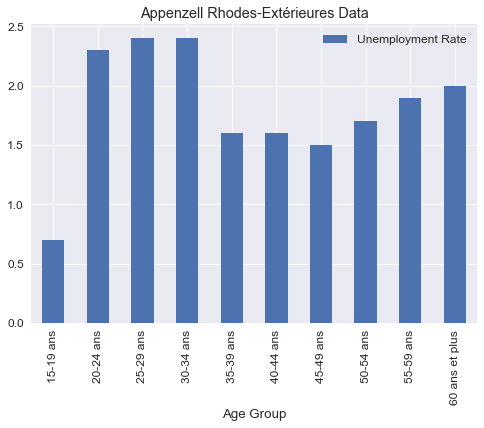

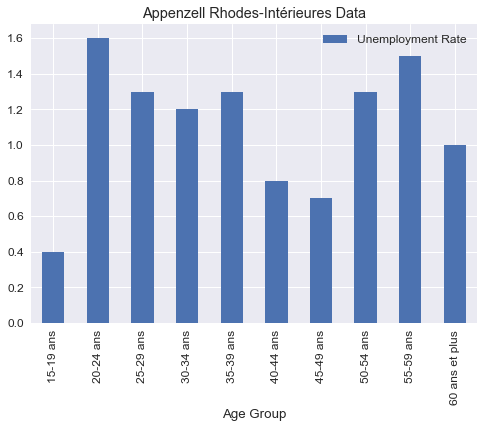

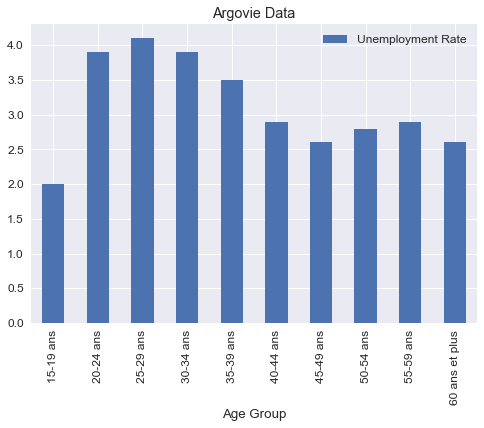

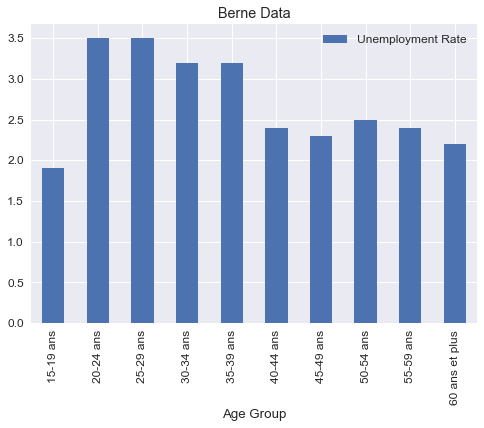

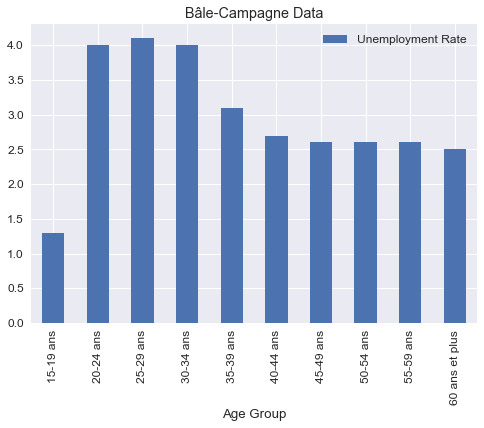

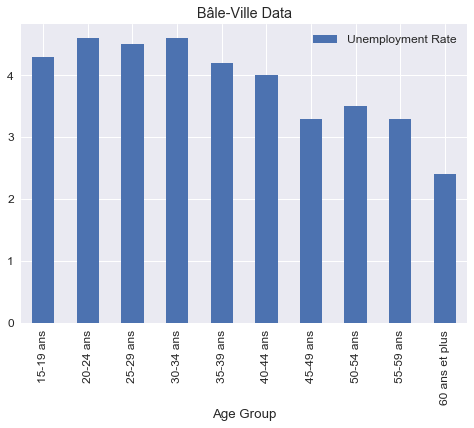

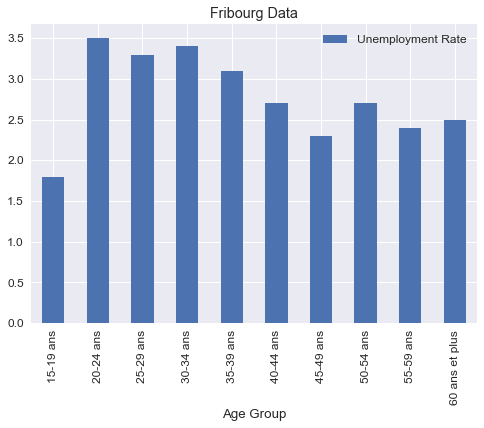

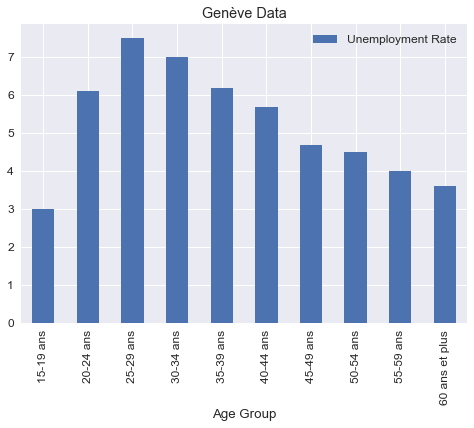

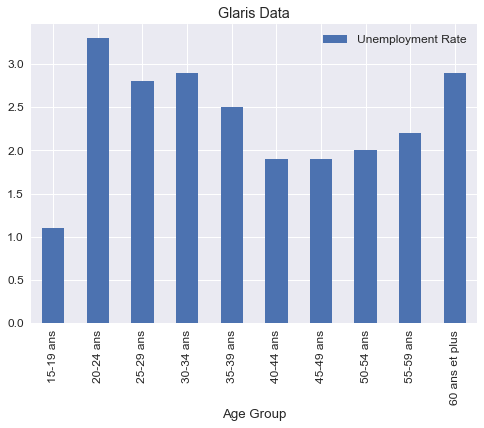

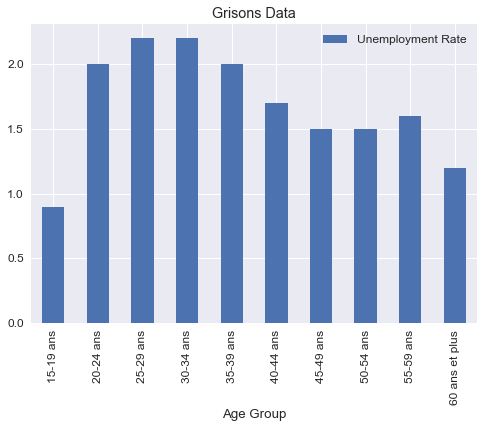

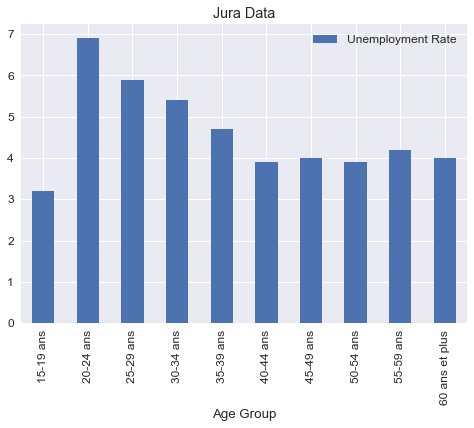

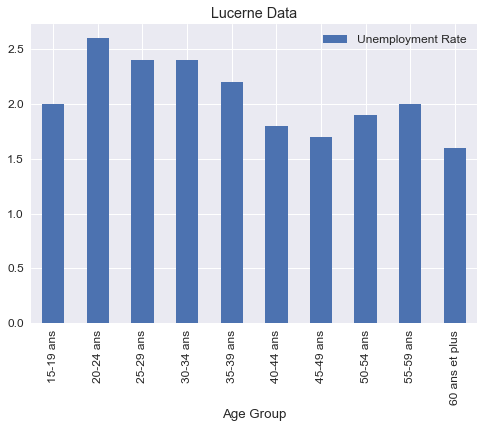

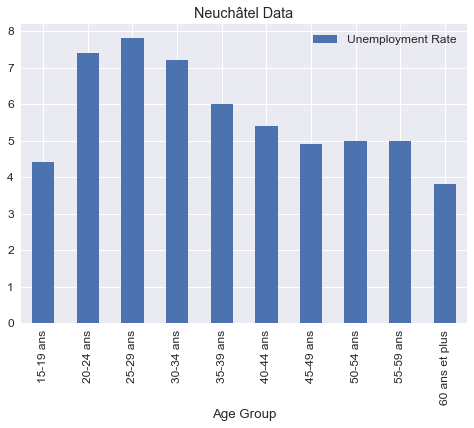

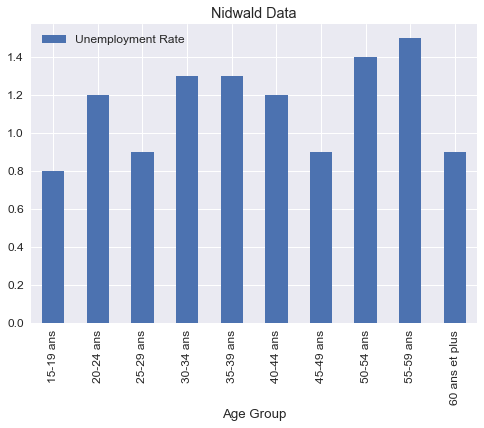

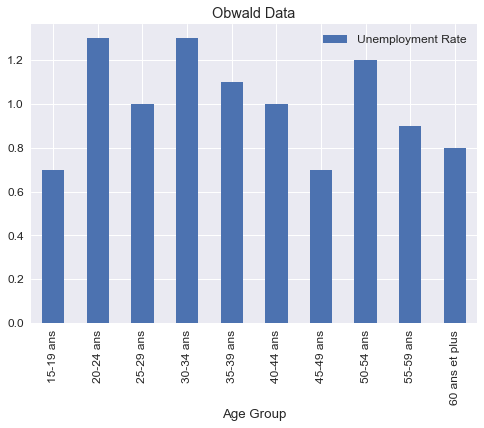

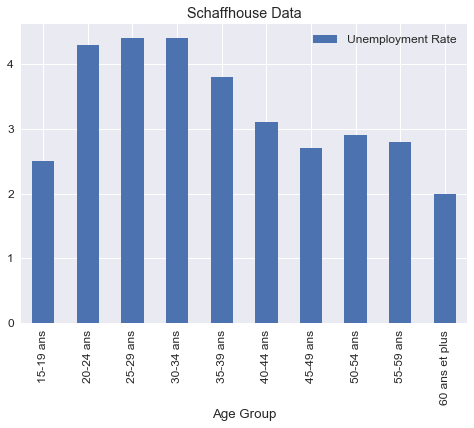

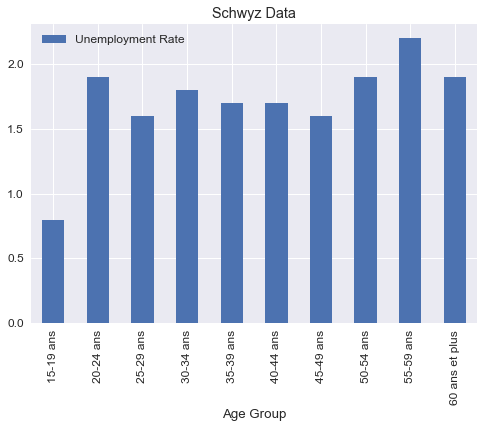

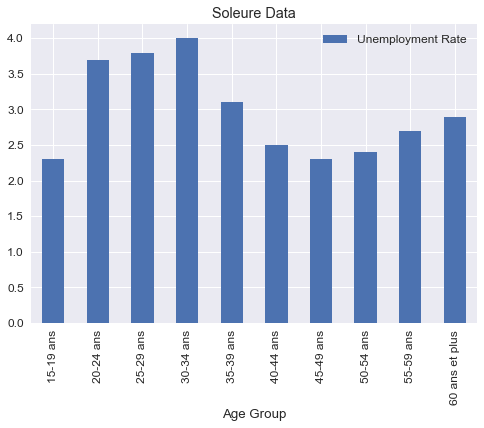

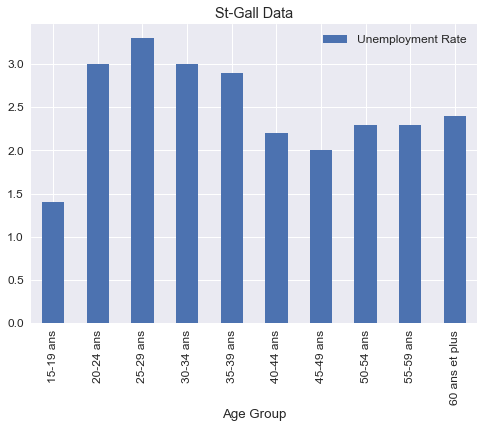

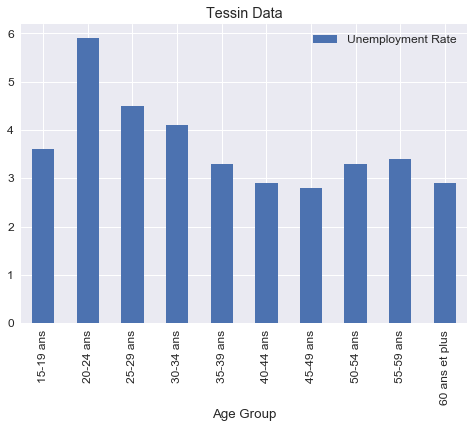

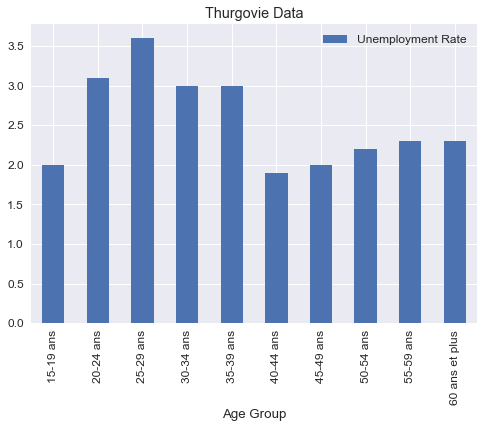

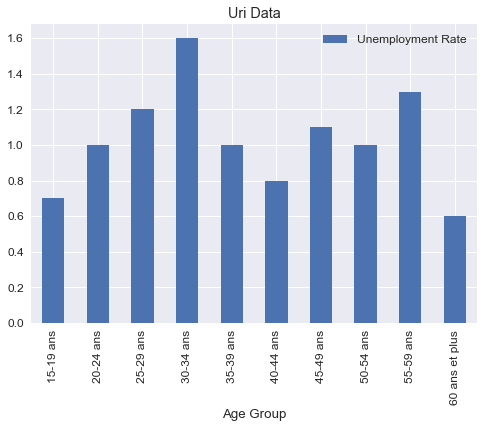

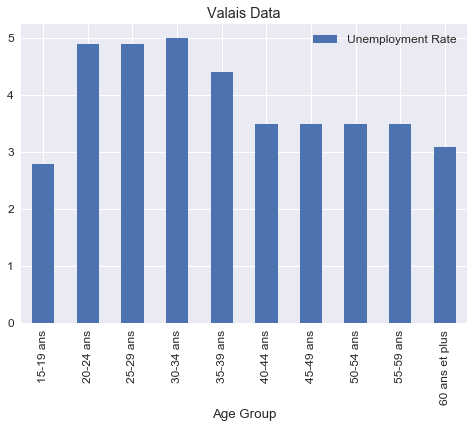

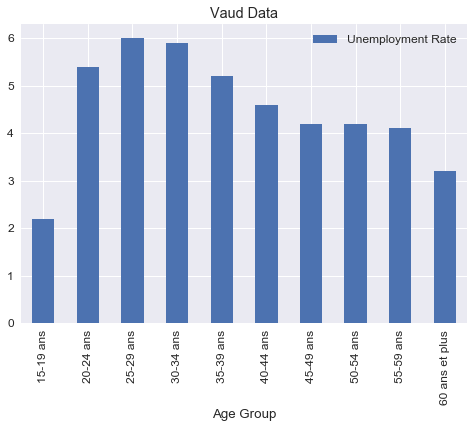

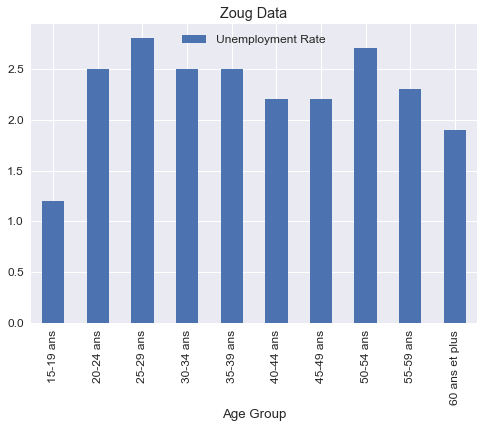

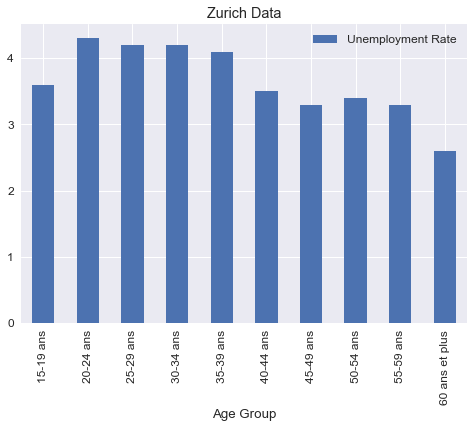

In [27]:
cantons = list(unemployment_ch_age.index.levels[0])
for canton in cantons:
    t = canton + ' Data'
    unemployment_ch_age.loc[canton].plot.bar(title = t)